In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import itertools
from pandas_datareader import data as pdr
import yfinance as yf
import datetime

In [166]:
df = pd.read_csv('12mo_stock_returns.csv')

In [167]:
df

,Unnamed: 0,GVKEY,iid,datadate,cusip,conm,prccm,trfm,trt1m,cshoq,cik,fic,gsector,naics,state,year,month,mkvalt,12mo return
0,18,1004,1,2010-01-31,000361105,AAR CORP,23.1700,2.2365,0.000083,NaN,1750.0,USA,20.0,423860.0,IL,2010,1,NaN,-0.003679
1,45,1004,1,2010-02-28,000361105,AAR CORP,22.6800,2.2365,-0.000211,39.025,1750.0,USA,20.0,423860.0,IL,2010,2,NaN,0.002614
2,105,1004,1,2010-03-31,000361105,AAR CORP,24.8200,2.2365,0.000944,NaN,1750.0,USA,20.0,423860.0,IL,2010,3,NaN,0.008078
3,88,1004,1,2010-04-30,000361105,AAR CORP,24.3800,2.2365,-0.000177,NaN,1750.0,USA,20.0,423860.0,IL,2010,4,NaN,0.000941
4,64,1004,1,2010-05-31,000361105,AAR CORP,19.7000,2.2365,-0.001920,39.484,1750.0,USA,20.0,423860.0,IL,2010,5,777.8348,0.002575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677738,677619,332115,1,2019-08-31,04216R102,ARMATA PHARMACEUTICALS INC,4.4521,1.0000,0.002684,NaN,921114.0,USA,35.0,325414.0,CA,2019,8,NaN,NaN
677739,677618,332115,1,2019-09-30,04216R102,ARMATA PHARMACEUTICALS INC,3.7000,1.0000,-0.001689,9.934,921114.0,USA,35.0,325414.0,CA,2019,9,NaN,NaN
677740,677617,332115,1,2019-10-31,04216R102,ARMATA PHARMACEUTICALS INC,4.1500,1.0000,0.001216,NaN,921114.0,USA,35.0,325414.0,CA,2019,10,NaN,NaN
677741,677616,332115,1,2019-11-30,04216R102,ARMATA PHARMACEUTICALS INC,4.3800,1.0000,0.000554,NaN,921114.0,USA,35.0,325414.0,CA,2019,11,NaN,NaN


In [168]:
def longshort(df,yearinput):
    df=df.sort_values(by='1', ascending=False)
    df['quantile'] = pd.qcut(df['1'],10, labels=['1','2','3','4','5','6','7','8','9','10'])
    #store the needed GVKEY into a list
    masklow=df['quantile']=='10'
    lowlist= list(df[masklow]['GVKEY'])
    
    
    
    maskhigh=df['quantile']=='1'
    highlist= list(df[maskhigh]['GVKEY'])
    
    
    print('Top Quantile has', len(highlist),' Companies')
    print('Bottom Quantile has', len(lowlist),' Companies')
    
    
    #all_fund and time reduction 
    all_fund = pd.read_csv('12mo_stock_returns.csv')
    all_fund['datadate']=(pd.to_datetime(all_fund['datadate']))
    all_fund['month']= all_fund['datadate'].dt.month
    all_fund['year']= all_fund['datadate'].dt.year
    maskyear= all_fund['year']>=yearinput
    all_fund=all_fund[maskyear]
    
    #shift return for allfund 
    
    mask = all_fund['GVKEY']==all_fund['GVKEY'].shift(-1)
    all_fund['next_month_return']= np.where(mask,all_fund['trt1m'].shift(-1),np.nan)
    
    
    #mask to only check the one in qcut
    maskhigh= all_fund['GVKEY'].isin(highlist)
    highdata=all_fund[maskhigh]
    
    masklow= all_fund['GVKEY'].isin(lowlist)
    lowdata=all_fund[masklow]
    
    
    highdata= highdata[['year','month','GVKEY','next_month_return']]
    lowdata= lowdata[['year','month','GVKEY','next_month_return']]

    
    
    #equal weight portfolio 
    
    temp=highdata.groupby(['year','month'])[['next_month_return']].agg('count').reset_index()
    temp2=lowdata.groupby(['year','month'])[['next_month_return']].agg('count').reset_index()
    mask= temp['year']==yearinput
    temp= temp[mask]
    mask= temp2['year']==yearinput
    temp2= temp2[mask]
    
    
    print('In the year', i, 'portfolio long on average', temp['next_month_return'].mean(),'Stock per month')
    print('In the year', i, 'portfolio short on average', temp2['next_month_return'].mean(),'Stock per month')
    print('')
    
    long_short= (highdata.groupby(['year','month'])[['next_month_return']].agg('mean'))-(lowdata.groupby(['year','month'])[['next_month_return']].agg('mean'))
    long_short=long_short.reset_index()
    
    #filterout not used year 
    mask= long_short['year']==yearinput
    long_short= long_short[mask]
    long_short['date']=pd.to_datetime(long_short[['year', 'month']].assign(Day=1))
    return(long_short)

In [169]:

file_name = 'port{}.csv'
df_list = []
for i in range(2011, 2018):
    df_list.append(longshort(pd.read_csv(file_name.format(i), index_col=0),i))

df = pd.concat(df_list)

Top Quantile has 347  Companies
Bottom Quantile has 347  Companies
In the year 2011 portfolio long on average 337.4166666666667 Stock per month
In the year 2011 portfolio short on average 332.25 Stock per month

Top Quantile has 340  Companies
Bottom Quantile has 337  Companies
In the year 2012 portfolio long on average 323.1666666666667 Stock per month
In the year 2012 portfolio short on average 316.1666666666667 Stock per month

Top Quantile has 342  Companies
Bottom Quantile has 342  Companies
In the year 2013 portfolio long on average 332.3333333333333 Stock per month
In the year 2013 portfolio short on average 302.8333333333333 Stock per month

Top Quantile has 354  Companies
Bottom Quantile has 354  Companies
In the year 2014 portfolio long on average 333.75 Stock per month
In the year 2014 portfolio short on average 312.9166666666667 Stock per month

Top Quantile has 350  Companies
Bottom Quantile has 350  Companies
In the year 2015 portfolio long on average 338.5 Stock per mont

In [170]:
df

,year,month,next_month_return,date
0,2011,1,0.000293,2011-01-01
1,2011,2,0.000391,2011-02-01
2,2011,3,0.000464,2011-03-01
3,2011,4,0.000419,2011-04-01
4,2011,5,0.000630,2011-05-01
...,...,...,...,...
7,2017,8,-0.000223,2017-08-01
8,2017,9,0.000600,2017-09-01
9,2017,10,0.000231,2017-10-01
10,2017,11,-0.000185,2017-11-01


## SP500 

In [171]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime

start_sp = datetime.datetime(1998, 1 , 1)
end_sp = datetime.datetime(2020, 1, 31)


yf.pdr_override() # <== that's all it takes :-)
sp500 = pdr.get_data_yahoo('^GSPC', 
                           start_sp,
                             end_sp)
sp500= sp500.reset_index()

sp500['year']=sp500['Date'].dt.year
sp500['month']=sp500['Date'].dt.month

sp500=sp500.drop_duplicates(subset=['year','month'], keep="last")

sp500['next_month_close']= sp500['Adj Close'].shift(-1)
sp500['mkt_return']= (sp500['next_month_close']-sp500['Adj Close'])*100/sp500['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [172]:
#merge dataframe 
regressiondata= pd.merge(df,sp500, left_on=['year','month'], right_on=['year','month'], how='left')

In [173]:
mask= regressiondata['next_month_return'].isnull()|regressiondata['mkt_return'].isnull()

In [174]:
import statsmodels.api as sm
x=regressiondata[~mask]['mkt_return']
y=regressiondata[~mask]['next_month_return']
x = sm.add_constant(x)

In [175]:
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     13.87
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           0.000358
Time:                        18:22:20   Log-Likelihood:                 532.76
No. Observations:                  84   AIC:                            -1062.
Df Residuals:                      82   BIC:                            -1057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   4.94e-05      8.127      0.0

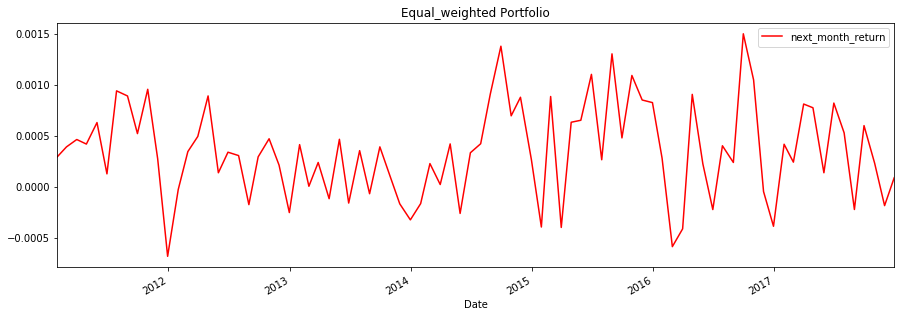

In [176]:
ax = regressiondata.plot(x = 'Date', y = 'next_month_return', title = 'Equal_weighted Portfolio', color = 'Red', figsize = (15,5))